In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib
import random
import math

In [2]:
FuncX = lambda x: np.exp(x * np.sin(x)) / (x**2 + 1)
x = np.random.uniform(-5, 5, size=[10000, 1])
x = x.reshape(10000)
x.sort()
x = x.reshape(10000, 1)
y = FuncX(x)
countOfHiddenNeuronsRBF = 7
countOfHiddenNeuronsPRC = 7
sigma=np.std(y)

In [3]:
interpMtx = np.zeros((len(x), countOfHiddenNeuronsRBF))
centers = x[np.random.choice(len(x), countOfHiddenNeuronsRBF)]
def rbf(point, center):
    return np.exp(-np.linalg.norm((point - center) ** 2 / (2 * sigma ** 2)))
for i in range(len(x)):
        for j in range(len(centers)):
            interpMtx[i, j] = rbf(x[i], centers[j])
weightsRBF = np.linalg.pinv(interpMtx) @ y

def predictRBF(x):
    mtx = np.zeros((len(x), countOfHiddenNeuronsRBF))
    for i in range(len(x)):
        for j in range(len(centers)):
            mtx[i, j] = rbf(x[i], centers[j])
    return mtx @ weightsRBF

print("RBF predict in 0:")
print(predictRBF([0]))
print("FuncX in 0:")
print(FuncX(0))

RBF predict in 0:
[[0.74141353]]
FuncX in 0:
1.0


In [4]:
def logistic(x):
    return 1.0/(1 + np.exp(-x))

def logistic_deriv(x):
    return logistic(x) * (1 - logistic(x))

LR = 1   

I_dim = 1
H_dim = 7

epoch_count = 10

weights_ItoH = np.random.uniform(-1, 1, (I_dim, H_dim))
weights_HtoO = np.random.uniform(-1, 1, H_dim)
preActivation_H = np.zeros(H_dim)
postActivation_H = np.zeros(H_dim)
def train1PRC(x, y):
    
    for epoch in range(epoch_count):
        print(str(epoch) + " / " + str(epoch_count))
        for sample in range(len(x)):
            for node in range(H_dim):
                preActivation_H[node] = np.dot(x[sample,:], weights_ItoH[:, node])
                postActivation_H[node] = (preActivation_H[node])
                
            preActivation_O = np.dot(postActivation_H, weights_HtoO)
            postActivation_O = preActivation_O
            
            FE = postActivation_O - y[sample]
            
            for H_node in range(H_dim):
                S_error = FE * logistic_deriv(preActivation_O)
                gradient_HtoO = S_error * postActivation_H[H_node]
                           
                for I_node in range(I_dim):
                    input_value = x[sample]
                    gradient_ItoH = S_error * weights_HtoO[H_node] * logistic_deriv(preActivation_H[H_node]) * input_value
                
                    weights_ItoH[I_node, H_node] -= LR * gradient_ItoH
                    
                weights_HtoO[H_node] -= LR * gradient_HtoO

In [5]:
train1PRC(x,y) 

0 / 10
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10


In [6]:
def init_parameters(n_features, n_neurons, n_output):   
    np.random.seed(100)
    W1 = np.random.uniform(size=(n_features,n_neurons), low=-1.0, high=1.0)
    b1 = np.zeros(shape=(1,n_neurons))
    b1 += 1
    W2 = np.random.uniform(size=(n_neurons,n_output), low=-1.0, high=1.0)
    b2 = np.zeros(shape=(1,n_output))
    b2 += 1
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters
def linear_function(W, X, b):
    
    return (X @ W)+b
def sigmoid_function(Z):
    
    return 1/(1+np.exp(-Z))
def cost_function(A, y):
    
    return (np.mean(np.power(A - y,2)))/2
def predict2PRC(X, W1, W2, b1, b2):
    
    Z1 = linear_function(W1, X, b1)
    S1 = Z1
    Z2 = linear_function(W2, S1, b2)
    S2 = Z2
    return S2
def fit2PRC(X, y, n_features=1, n_neurons=7, n_output=1, iterations=50, eta=0.01):
    param = init_parameters(n_features=n_features, 
                            n_neurons=n_neurons, 
                            n_output=n_output)
    errors = []
    
    for _ in range(iterations):
        Z1 = linear_function(param['W1'], X, param['b1'])
        S1 = Z1
        Z2 = linear_function(param['W2'], S1, param['b2'])
        S2 = Z2

        error = cost_function(S2, y)
        errors.append(error)

        delta2 = (S2 - y)*eta
        W2_gradients = S1.T @ delta2
        param["W2"] = param["W2"] - W2_gradients * eta

        param["b2"] = param["b2"] - np.sum(delta2, axis=0, keepdims=True) * eta

        delta1 = (delta2 @ param["W2"].T )*eta
        W1_gradients = X.T @ delta1 
        param["W1"] = param["W1"] - W1_gradients * eta

        param["b1"] = param["b1"] - np.sum(delta1, axis=0, keepdims=True) * eta
        
    return errors, param

In [7]:
errors, param = fit2PRC(x, y, iterations=5000, eta=0.001)
y_pred = predict2PRC(x, param["W1"], param["W2"], param["b1"], param["b2"])

In [8]:
class Perceptron:
    def __init__(self, l_rate=0.1):
        self.layers = []
        self.l_rate = l_rate
        self.out = 0

    def append_layer(self, n_inputs, n_output, existBias=False, isActivate = False):
        self.layers.append(PerceptronLayer(n_inputs, n_output, existBias, isActivate))

    def forward_propagate(self, x):
        out = x
        for layer in self.layers:
            out = layer.forward_propagate(out)
        self.out = out
        return out

    def backward_propagate(self, y):
        error = self.out - y
        for i in reversed(range(len(self.layers))):
            if i != len(self.layers)-1:
                self.layers[i].backward_propagate(self.layers[i+1].neurons,False, error)
            else:
                self.layers[i].backward_propagate(None, True, y)
            

    def update_weights(self, row):
        for i in range(len(self.layers)):
            inputs = row[:-1]
            if i != 0:
                inputs = [neuron['output'] for neuron in self.layers[i - 1].neurons]
                if i != 1:
                    oldInputs = inputs
                    inputs = []
                    for j in range(len(oldInputs)):
                        current = oldInputs[j]
                        previousInputs = [neuron['output'] for neuron in self.layers[i - 2].neurons]
                        sumIn = 0
                        for item in previousInputs:
                            sumIn += item * current
                        inputs.append(sumIn)
            for neuron in self.layers[i].neurons:
                for j in range(len(inputs)):
                    neuron['weights'][j] -= self.l_rate * neuron['delta'] * inputs[j]
                neuron['weights'][-1] -= self.l_rate * neuron['delta']
    def fit(self, dataset):
        for _ in range(25):
            for row in dataset:
                self.forward_propagate(row)
                self.backward_propagate(row[-1])
                self.update_weights(row)
    def predict(self, x_list):
        result = []
        for x in x_list:
            result.append(self.forward_propagate(x))
        return result
class PerceptronLayer:
    def __init__(self, n_inputs, n_output, existBias=False, isActivate = False):
        if existBias:
            n_inputs += 1
        self.neurons = [{'weights': [np.random.uniform(-np.sqrt(1 / n_inputs), np.sqrt(1 / n_inputs)) for i in range(n_inputs)]}
                        for i in range(n_output)]
        self.existBias = existBias
        self.isActivate = isActivate

    def transfer(self, activation):
        if self.isActivate:
            return 1.0 / (1.0 + math.exp(-activation))
        return activation

    def transfer_derivative(self, output):
        if self.isActivate:
            return output * (1.0 - output)
        return 1

    def activate(self, weights, inputs):
        activation = weights[-1]
        for i in range(len(weights)-1):
            activation += weights[i] * inputs[i]
        return activation

    def forward_propagate(self, x):
        new_inputs = []
        for neuron in self.neurons:
            activation = self.activate(neuron['weights'], x)
            neuron['output'] = self.transfer(activation)
            new_inputs.append(neuron['output'])
        return new_inputs

    def backward_propagate(self, nextNeurons = None, isLast = False, y = None):
        errors = list()
        if not isLast:
            for j in range(len(self.neurons)):
                error = 0.0
                for neuron in nextNeurons:
                    error += (neuron['weights'][j] * neuron['delta'])
                    errors.append(error)
        else:
            for j in range(len(self.neurons)):
                neuron = self.neurons[j]
                errors.append(neuron['output'] - y)
        for j in range(len(self.neurons)):
            neuron = self.neurons[j]
            neuron['delta'] = errors[j] * \
                self.transfer_derivative(neuron['output'])

In [9]:
perc = Perceptron()
perc.fit(y)
y_perc = perc.predict(y)

In [10]:
y_perc_pred = []
for i in y_perc:
  y_perc_pred.append(i[0])

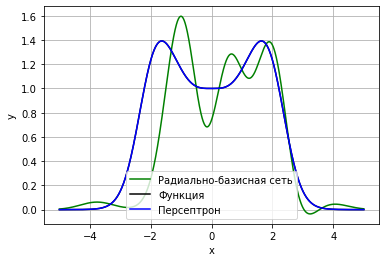

In [11]:
plt.plot(x, predictRBF(x), "g", label="Радиально-базисная сеть")
plt.plot(x, y, "black", label="Функция")
plt.plot(x, y_perc_pred, "b", label="Персептрон")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid()
plt.show()

In [12]:
y = np.array([[7.17],[7.18],[7.17],[7.19],[7.19],[7.19],[7.20],[7.20],[7.23],[7.22],[7.24],[7.24],[7.24],[7.26],[7.30],[7.17],[7.23],[7.25],[7.25],[7.25],[7.30],[7.28],[7.29],[7.30],[7.19],[7.18],[7.18],[7.23],[7.25],[7.24],[7.19]])
x = np.array([[1],[2],[3],[4],[5],[6],[7],[8],[9],[10],[11],[12],[13],[14],[15],[16],[17],[18],[19],[20],[21],[22],[23],[24],[25],[26],[27],[28],[29],[30],[31]])

interpMtx = np.zeros((len(x), countOfHiddenNeuronsRBF))
centers = x[np.random.choice(len(x), countOfHiddenNeuronsRBF)]

def rbf(point, center):
    return np.exp(-np.linalg.norm((point - center) ** 2 / (2 * sigma ** 2)))

for i in range(len(x)):
    for j in range(len(centers)):
        interpMtx[i, j] = rbf(x[i], centers[j])

weightsRBF = np.linalg.pinv(interpMtx) @ y

def predictZAD2(x):
    mtx = np.zeros((len(x), countOfHiddenNeuronsRBF))
    for i in range(len(x)):
        for j in range(len(centers)):
            mtx[i, j] = rbf(x[i], centers[j])
    return mtx @ weightsRBF

In [13]:
y = np.array([7.17,7.18,7.17,7.19,7.19,7.19,7.20,7.20,7.23,7.22,7.24,7.24,7.24,7.26,7.30,7.17,7.23,7.25,7.25,7.25,7.30,7.28,7.29,7.30,7.19,7.18,7.18,7.23,7.25,7.24,7.19])

In [14]:
class RecurrentNeuralNetwork:
    def __init__(self, input_number, hidden_number, output_number, l_rate=0.1):
        self.l_rate = l_rate
        self.w1 = np.random.uniform(-np.sqrt(1 / input_number), np.sqrt(1 / input_number), size=[input_number, hidden_number])
        self.b1 = np.random.uniform(size=[1, hidden_number])
        self.w2 = np.random.uniform(-np.sqrt(1 / hidden_number), np.sqrt(1 / hidden_number), size=[hidden_number, hidden_number])
        self.b2 = np.random.uniform(size=[1, hidden_number])
        self.h = np.zeros(shape=[1, hidden_number])
        self.h_prev = np.zeros(shape=[1, hidden_number])
        self.w3 = np.random.uniform(-np.sqrt(1 / hidden_number), np.sqrt(1 / hidden_number), size=[hidden_number, output_number])

    def transfer(self, x):
        return np.tanh(x)

    def transfer_derivative(self, output):
        return (1 - np.tanh(output) ** 2)

    def forward_propagate(self, x):
        self.x = x
        self.h_prev = self.h
        self.h = np.dot(self.x,self.w1) + self.b1 + np.dot(self.h_prev,self.w2) + self.b2
        self.h = self.transfer(self.h)
        self.output = np.dot(self.h,self.w3)
        return self.output
    
    def backward_propagate(self, y):
        error = self.output - y
        self.dw = np.dot(self.h.T,error)
        delta = self.transfer_derivative(self.h) * np.dot(error,self.w3.T)
        self.dw_w1 = np.dot(self.x.T,delta)
        self.db_b1 = delta
        self.dw_w2 = np.dot(self.h_prev.T,delta)
        self.db_b2 = delta
        
    def update_weights(self):
        self.w1 -= self.l_rate * self.dw_w1
        self.b1 -= self.l_rate * self.db_b1
        self.w2 -= self.l_rate * self.dw_w2
        self.b2 -= self.l_rate * self.db_b2
        self.w3 -= self.l_rate * self.dw

class SlidingLayer:
    def __init__(self, n_inputs, n_output, isActivate = False):
               
        self.weight = np.random.uniform(low=-np.sqrt(1 / n_inputs), 
            high=np.sqrt(1 / n_inputs), size=[n_inputs, n_output])

        self.isActivate = isActivate

    def transfer(self, activation):
        if self.isActivate:
            return np.tanh(activation)
        return activation

    def transfer_derivative(self, output):
        if self.isActivate:
            return 1 - np.tanh(output) ** 2
        return 1

    def forward_propagate(self, x):
        self.input = x
        self.not_activated = np.dot(x,self.weight)
        self.out = self.transfer(self.not_activated)
        return self.out
    
    def backward_propagate(self, error):
        delta = error * self.transfer_derivative(self.not_activated)
        self.dw = np.dot(self.input.T,delta)
        return np.dot(delta,self.weight.T)


class SlidingPerceptron:
    def __init__(self, l_rate=0.1):
        self.l_rate = l_rate
        self.layers = []        
        self.output = 0
        
    def append_layer(self, n_inputs, n_output, isActivate = False):
        self.layers.append(SlidingLayer(n_inputs, n_output, isActivate))
    
    def forward_propagate(self, input):
        self.output = input
        for layer in self.layers:
            self.output = layer.forward_propagate(self.output)
        return self.output
    
    def backward_propagate(self, y):
        error = self.output - y
        for layer in list(reversed(self.layers)):
            error = layer.backward_propagate(error)
    
    def update_weights(self):
        for layer in self.layers:
            layer.weight -= self.l_rate * layer.dw

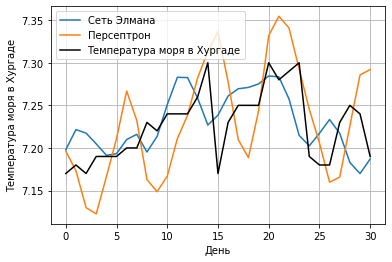

In [15]:
class RNN:
    def __init__(self, input_number, hidden_number, output_number, lr=0.01):
        self.lr = lr

        self.w_ih = np.random.uniform(-np.sqrt(1 / input_number), np.sqrt(1 / input_number), 
            size=[input_number, hidden_number])
        self.b_ih = np.random.uniform(size=[1, hidden_number])

        self.w_hh = np.random.uniform(-np.sqrt(1 / hidden_number), np.sqrt(1 / hidden_number), 
            size=[hidden_number, hidden_number])
        self.b_hh = np.random.uniform(size=[1, hidden_number])

        self.h = np.zeros(shape=[1, hidden_number])
        self.h_t_1 = np.zeros(shape=[1, hidden_number])

        self.w = np.random.uniform(-np.sqrt(1 / hidden_number), np.sqrt(1 / hidden_number), 
            size=[hidden_number, output_number])
        
    def forward(self, x):
        self.x = x
        self.h_t_1 = self.h
        self.h = self.x @ self.w_ih + self.b_ih + self.h_t_1 @ self.w_hh + self.b_hh
        self.h = np.tanh(self.h)
        self.out = self.h @ self.w
        return self.out
    
    def __call__(self, *args):
        return self.forward(*args)
    
    def backward(self, y):
        dloss = self.out - y
        self.dw = self.h.T @ dloss
        dh = dloss @ self.w.T
        grad = (1 - np.tanh(self.h) ** 2) * dh
        self.dw_ih = self.x.T @ grad
        self.db_ih = 1 * grad
        self.dw_hh = self.h_t_1.T @ grad
        self.db_hh = 1 * grad
        
    def update(self):
        self.w -= self.lr * self.dw
        self.w_ih -= self.lr * self.dw_ih
        self.b_ih -= self.lr * self.db_ih
        self.w_hh -= self.lr * self.dw_hh
        self.b_hh -= self.lr * self.db_hh

sequence_len = 20
dataset = y

mean = np.mean(dataset)
std = np.std(dataset)
rnn = RecurrentNeuralNetwork(sequence_len, 31, 1, 0.002)
perceptron = SlidingPerceptron(0.002)
perceptron.append_layer(sequence_len, 31, isActivate = True)
perceptron.append_layer(31, 1)
for epoch in range(2500):
    q = np.random.randint(0, sequence_len)
    for i in range(q, len(dataset) - sequence_len, sequence_len):
        x = (np.array(dataset[i : i+sequence_len]).reshape(1, sequence_len) - mean) / std
        y = (np.array(dataset[i+sequence_len : i+sequence_len+1]).reshape(1, 1) - mean) / std
        rnn.forward_propagate(x)
        rnn.backward_propagate(y)
        rnn.update_weights()
        perceptron.forward_propagate(x)
        perceptron.backward_propagate(y)
        perceptron.update_weights()
rnn_y = []
perceptron_y = []

for i in dataset[-sequence_len:]:
    rnn_y.append((i - mean) / std)
    perceptron_y.append((i - mean) / std)

for i in range(len(dataset)):
    out_rnn = rnn.forward_propagate(np.array(rnn_y[i:i+sequence_len]).reshape(1, sequence_len)).reshape(-1)
    out_perceptron = perceptron.forward_propagate(np.array(perceptron_y[i:i+sequence_len]).reshape(1, sequence_len)).reshape(-1)
    rnn_y.append(out_rnn[0])
    perceptron_y.append(out_perceptron[0])
    
elpred = np.array(rnn_y[sequence_len:]) * std + mean
perpred = np.array(perceptron_y[sequence_len:])* std + mean
plt.plot(elpred, label="Сеть Элмана")
plt.plot(perpred, label="Персептрон")
y = np.array([[7.17],[7.18],[7.17],[7.19],[7.19],[7.19],[7.20],[7.20],[7.23],[7.22],[7.24],[7.24],[7.24],[7.26],[7.30],[7.17],[7.23],[7.25],[7.25],[7.25],[7.30],[7.28],[7.29],[7.30],[7.19],[7.18],[7.18],[7.23],[7.25],[7.24],[7.19]])
plt.plot(y,"black", label="Температура моря в Хургаде")
plt.xlabel("День")
plt.ylabel("Температура моря в Хургаде")
plt.legend()
plt.grid()
plt.show()

In [16]:
y = np.array([7.17,7.18,7.17,7.19,7.19,7.19,7.20,7.20,7.23,7.22,7.24,7.24,7.24,7.26,7.30,7.17,7.23,7.25,7.25,7.25,7.30,7.28,7.29,7.30,7.19,7.18,7.18,7.23,7.25,7.24,7.19])

In [17]:
for i in range(len(perpred)):
  perpred[i] = round(perpred[i], 2)
  elpred[i] = round(elpred[i], 2)

In [18]:
print("Персептрон: ")
print(perpred)
print("Сеть Элмана: ")
print(elpred)
print("Исходные данные: ")
print(y)

Персептрон: 
[7.2  7.17 7.13 7.12 7.17 7.21 7.27 7.23 7.16 7.15 7.17 7.21 7.24 7.28
 7.31 7.34 7.28 7.21 7.19 7.24 7.33 7.35 7.34 7.29 7.25 7.21 7.16 7.17
 7.23 7.29 7.29]
Сеть Элмана: 
[7.2  7.22 7.22 7.2  7.19 7.19 7.21 7.22 7.2  7.21 7.25 7.28 7.28 7.26
 7.23 7.24 7.26 7.27 7.27 7.28 7.28 7.28 7.26 7.21 7.2  7.22 7.23 7.22
 7.18 7.17 7.19]
Исходные данные: 
[7.17 7.18 7.17 7.19 7.19 7.19 7.2  7.2  7.23 7.22 7.24 7.24 7.24 7.26
 7.3  7.17 7.23 7.25 7.25 7.25 7.3  7.28 7.29 7.3  7.19 7.18 7.18 7.23
 7.25 7.24 7.19]


In [19]:
perp_acc = 0
el_acc = 0

for i in range(len(perpred)):
  if abs(y[i] - perpred[i]) <= 0.07:
    perp_acc += 1
  if abs(y[i] - elpred[i]) <= 0.07:
    el_acc += 1

perp_acc /= round(len(perpred), 2)
el_acc /= round(len(elpred), 2)

In [20]:
print("Точность на персептроне: " + str(perp_acc))
print("Точность на сети Элмана: " + str(el_acc))

Точность на персептроне: 0.8387096774193549
Точность на сети Элмана: 0.8709677419354839
